# $270K in One Week: Inside the Strategies of Polymarket's Top Crypto Traders

Polymarket's 15-minute crypto prediction markets ("Will BTC go Up or Down in the next 15 minutes?") have exploded in popularity. With markets running around the clock across **BTC, ETH, SOL, and XRP**, they generate massive trading volume and attract a diverse crowd of speculators, market makers, and sharp traders.

**In this analysis, we dig into 1 week of on-chain trading data to find out:**
- Who are the most profitable wallets?
- How much money is flowing through these markets?
- What separates winners from losers?

*Data sourced from [Telonex](https://telonex.io) — granular prediction market data for research and trading.*

**Read the full article: [Inside the Strategies Behind Polymarket's Most Profitable 15-Minute Traders](http://telonex.io/research/top-crypto-traders-polymarket-15m)**

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
from datetime import datetime, timezone
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from telonex import get_markets_dataframe, get_dataframe, NotFoundError
from tqdm.std import tqdm

# ── Config ──
from dotenv import load_dotenv
_env_path = Path("../../.env")
load_dotenv(_env_path)
API_KEY = os.environ["TELONEX_API_KEY"]

# Resolve DOWNLOAD_DIR relative to .env file, not the notebook
_raw_dir = os.environ.get("TELONEX_DOWNLOAD_DIR", "./datasets")
DOWNLOAD_DIR = str((_env_path.parent / _raw_dir).resolve())

MAX_WORKERS = 20

# ── Chart export directory (local to notebook) ──
IMG_DIR = Path("./output")
IMG_DIR.mkdir(exist_ok=True)

# ── Telonex brand colors ──
TEAL     = '#0C5B44'
CYAN     = '#2DD4BF'
DARK     = '#0F1929'
LIGHT_BG = '#F0F4F9'
MUTED    = '#6B7280'
GREEN    = '#10B981'
RED      = '#EF4444'
AMBER    = '#F59E0B'

# ── Plot style ──
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'figure.dpi': 120,
    'savefig.dpi': 150,
    'axes.edgecolor': MUTED,
    'axes.labelcolor': DARK,
    'xtick.color': MUTED,
    'ytick.color': MUTED,
    'text.color': DARK,
})

pd.set_option("display.width", 10000)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', None)

## 1. The 15M Crypto Universe

First, let's load all Polymarket markets tagged **15M** and filter to the resolved ones from the past week.

In [2]:
markets = get_markets_dataframe(exchange="polymarket", download_dir=DOWNLOAD_DIR)

In [3]:
# Fixed 1-week window: Feb 2 – Feb 8 inclusive
DATE_FROM = "2026-02-02"
DATE_TO   = "2026-02-08"

ts_from = int(datetime.strptime(DATE_FROM, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp())
ts_to   = int(datetime.strptime(DATE_TO,   "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp()) + 86400  # end of day

# Filter 15M markets and extract the start timestamp from the slug
all_15m = markets[markets["tags"].apply(lambda t: "15M" in t)].copy()
all_15m["market_ts"] = all_15m["slug"].str.extract(r"(\d+)$").astype(int)

markets_15m = all_15m[
    (all_15m["status"] == "resolved")
    & (all_15m["onchain_fills_from"] != "")
    & (all_15m["market_ts"] >= ts_from)
    & (all_15m["market_ts"] < ts_to)
].copy()

# Parse coin from slug  (e.g. "btc-updown-15m-..." -> BTC)
markets_15m["coin"] = markets_15m["slug"].str.split("-").str[0].str.upper()

print(f"Resolved 15M markets (Feb 2 - Feb 8): {len(markets_15m):,}")
print(f"Coins: {markets_15m['coin'].value_counts().to_dict()}")
print(f"Fills data range: {markets_15m['onchain_fills_from'].min()} to {markets_15m['onchain_fills_to'].max()} (includes pre/post-market fills)")

Resolved 15M markets (Feb 2 - Feb 8): 2,688
Coins: {'BTC': 672, 'XRP': 672, 'ETH': 672, 'SOL': 672}
Fills data range: 2026-02-01 to 2026-02-10 (includes pre/post-market fills)


## 2. Downloading On-Chain Fills

We pull **on-chain fill data** for every resolved 15M market. Each fill records the maker wallet, taker wallet, price, and size — everything we need to compute PnL.

We only need to download the first outcome token per market (the *Up* token). The dataset includes mirrored rows for *Down*-side fills, giving us complete coverage of every trade.

In [4]:
COLS = ["block_timestamp_us", "asset_id", "maker_asset_id", "taker_asset_id",
        "market_id", "maker", "taker", "maker_side", "taker_side", "amount", "price"]

def load_market_fills(row):
    """Download + read onchain fills for one market's Up token."""
    try:
        df = get_dataframe(
            api_key=API_KEY, exchange="polymarket", channel="onchain_fills",
            asset_id=row["asset_id_0"],
            from_date=row["onchain_fills_from"], to_date=row["onchain_fills_to"],
            download_dir=DOWNLOAD_DIR, engine="pandas",
        )
        return df[COLS]
    except NotFoundError:
        return None
    except Exception as e:
        return e

dfs, errors = [], []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
    futures = {pool.submit(load_market_fills, row): i for i, row in markets_15m.iterrows()}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Loading fills"):
        res = fut.result()
        if isinstance(res, pd.DataFrame):
            dfs.append(res)
        elif isinstance(res, Exception):
            errors.append(res)

fills = pd.concat(dfs, ignore_index=True)
print(f"Fills loaded: {len(fills):,}  |  Errors: {len(errors)}")

Loading fills: 100%|██████████| 2688/2688 [05:50<00:00,  7.67it/s]


Fills loaded: 15,352,455  |  Errors: 0


## 3. Computing Wallet-Level PnL

For every fill we know the price paid and the market's outcome. The **maker** places a resting order on the book; the **taker** fills it. The PnL formula is simple:

| Action | Settles at $1 (token won) | Settles at $0 (token lost) |
|--------|---------------------------|----------------------------|
| **Buy** at price *p* | $(1-p) \times \text{amount}$ | $-p \times \text{amount}$ |
| **Sell** at price *p* | $-(1-p) \times \text{amount}$ | $p \times \text{amount}$ |

Each fill generates a PnL entry for both the maker and the taker wallet.

In [5]:
# ── Type conversions ──
fills["price"]  = fills["price"].astype(float)
fills["amount"] = fills["amount"].astype(float)
fills["timestamp"] = pd.to_datetime(fills["block_timestamp_us"], unit="us", utc=True)

# ── Join market metadata ──
meta = markets_15m.set_index("asset_id_0")[["result_id", "coin"]]
fills = fills.join(meta, on="asset_id")
fills = fills.dropna(subset=["result_id"])

# Settlement value for the Up token (asset_id_0)
fills["sval"] = (fills["result_id"] == "0").astype(float)

# ── Canonical side relative to the Up token ──
def canonical(side_col, asset_col):
    same = fills[asset_col] == fills["asset_id"]
    return np.where(same, fills[side_col],
                    np.where(fills[side_col] == "buy", "sell", "buy"))

fills["taker_cs"] = canonical("taker_side", "taker_asset_id")
fills["maker_cs"] = canonical("maker_side", "maker_asset_id")

# ── PnL per fill ──
def pnl(cs_col):
    buy = fills[cs_col] == "buy"
    return np.where(buy,
                    (fills["sval"] - fills["price"]) * fills["amount"],
                    (fills["price"] - fills["sval"]) * fills["amount"])

fills["taker_pnl"] = pnl("taker_cs")
fills["maker_pnl"] = pnl("maker_cs")

# ── USDC volume from each participant's perspective ──
fills["taker_vol"] = np.where(
    fills["taker_asset_id"] == fills["asset_id"],
    fills["price"] * fills["amount"],
    (1 - fills["price"]) * fills["amount"],
)
fills["maker_vol"] = np.where(
    fills["maker_asset_id"] == fills["asset_id"],
    fills["price"] * fills["amount"],
    (1 - fills["price"]) * fills["amount"],
)

# Sanity check: zero-sum
total_pnl_check = fills["taker_pnl"].sum() + fills["maker_pnl"].sum()
print(f"Total fills: {len(fills):,}")
print(f"Sanity check (should be ~0): ${total_pnl_check:,.2f}")

Total fills: 15,352,455
Sanity check (should be ~0): $0.00


In [6]:
# ── Build per-wallet entries (one row per fill x role) ──
parts = []
for role, wcol, pcol, scol, vcol in [
    ("taker", "taker", "taker_pnl", "taker_cs", "taker_vol"),
    ("maker", "maker", "maker_pnl", "maker_cs", "maker_vol"),
]:
    tmp = fills[[wcol, pcol, scol, vcol, "coin", "timestamp", "market_id"]].copy()
    tmp.columns = ["wallet", "pnl", "side", "usdc_vol", "coin", "timestamp", "market_id"]
    tmp["role"] = role
    parts.append(tmp)

wallet_fills = pd.concat(parts, ignore_index=True)

# ── Aggregate per wallet ──
wallet_stats = wallet_fills.groupby("wallet").agg(
    total_pnl    = ("pnl",      "sum"),
    num_fills    = ("pnl",      "count"),
    volume       = ("usdc_vol", "sum"),
    num_markets  = ("market_id", "nunique"),
    fav_coin     = ("coin",     lambda x: x.value_counts().index[0]),
).reset_index()

# Maker ratio (by fills and by volume)
maker_part = wallet_fills[wallet_fills["role"] == "maker"].groupby("wallet").agg(
    maker_fills = ("pnl", "count"),
    maker_vol   = ("usdc_vol", "sum"),
)
wallet_stats = wallet_stats.merge(maker_part, on="wallet", how="left")
wallet_stats[["maker_fills", "maker_vol"]] = wallet_stats[["maker_fills", "maker_vol"]].fillna(0)
wallet_stats["maker_fill_pct"] = wallet_stats["maker_fills"] / wallet_stats["num_fills"]
wallet_stats["maker_vol_pct"]  = wallet_stats["maker_vol"]   / wallet_stats["volume"].replace(0, np.nan)

# Per-market averages
wallet_stats["fills_per_market"] = wallet_stats["num_fills"] / wallet_stats["num_markets"]
wallet_stats["vol_per_market"]   = wallet_stats["volume"]    / wallet_stats["num_markets"]
wallet_stats["pnl_per_market"]   = wallet_stats["total_pnl"] / wallet_stats["num_markets"]

wallet_stats = wallet_stats.sort_values("total_pnl", ascending=False).reset_index(drop=True)

print(f"Unique wallets: {len(wallet_stats):,}")

Unique wallets: 46,945


## 4. The Big Picture

In [7]:
n_wallets    = len(wallet_stats)
n_markets    = len(markets_15m)
pct_profit   = (wallet_stats["total_pnl"] > 0).mean()
total_vol    = fills["taker_vol"].sum()
total_fills  = len(fills)
top          = wallet_stats.iloc[0]
bottom       = wallet_stats.iloc[-1]

# Per-market stats
market_agg = fills.groupby("asset_id").agg(
    fills    = ("price", "count"),
    volume   = ("taker_vol", "sum"),
    wallets  = ("taker", "nunique"),
)

print("=" * 64)
print("   POLYMARKET 15M CRYPTO MARKETS — Feb 2 to Feb 8, 2026")
print("=" * 64)
print(f"  Markets analysed:           {n_markets:>10,}")
print(f"  On-chain fills:             {total_fills:>10,}")
print(f"  Total volume (USDC):        ${total_vol:>13,.0f}")
print(f"  Unique wallets:             {n_wallets:>10,}")
print(f"  Profitable wallets:         {pct_profit:>10.1%}")
print(f"  Biggest winner PnL:         ${top['total_pnl']:>13,.0f}")
print(f"  Biggest loser PnL:          ${bottom['total_pnl']:>13,.0f}")
print()
print("  --- Per 15-minute market (avg / median) ---")
print(f"  Fills per market:           {market_agg['fills'].mean():>8,.0f}  /  {market_agg['fills'].median():>8,.0f}")
print(f"  Volume per market:          ${market_agg['volume'].mean():>9,.0f}  /  ${market_agg['volume'].median():>9,.0f}")
print(f"  Unique takers per market:   {market_agg['wallets'].mean():>8,.0f}  /  {market_agg['wallets'].median():>8,.0f}")
print("=" * 64)

   POLYMARKET 15M CRYPTO MARKETS — Feb 2 to Feb 8, 2026
  Markets analysed:                2,688
  On-chain fills:             15,352,455
  Total volume (USDC):        $  152,579,869
  Unique wallets:                 46,945
  Profitable wallets:              36.8%
  Biggest winner PnL:         $      270,569
  Biggest loser PnL:          $     -139,971

  --- Per 15-minute market (avg / median) ---
  Fills per market:              5,711  /     2,536
  Volume per market:          $   56,763  /  $   22,964
  Unique takers per market:        646  /       373


## 5. Top 20 Most Profitable Wallets

In [8]:
def short(addr):
    return f"{addr[:6]}...{addr[-4:]}"

top20 = wallet_stats.head(20).copy()
top20.insert(0, "rank", range(1, 21))
top20["wallet"] = top20["wallet"].apply(short)

show = top20[["rank", "wallet", "total_pnl", "num_fills", "volume",
              "maker_fill_pct", "maker_vol_pct", "fills_per_market", "vol_per_market",
              "pnl_per_market", "num_markets", "fav_coin"]].copy()
show.columns = ["#", "Wallet", "PnL ($)", "Fills", "Volume ($)",
                "Maker % (fills)", "Maker % (vol)", "Fills/Mkt", "Vol/Mkt ($)",
                "PnL/Mkt ($)", "Markets", "Fav Coin"]

show["PnL ($)"]         = show["PnL ($)"].map("${:,.0f}".format)
show["Volume ($)"]      = show["Volume ($)"].map("${:,.0f}".format)
show["Maker % (fills)"] = show["Maker % (fills)"].map("{:.0%}".format)
show["Maker % (vol)"]   = show["Maker % (vol)"].map("{:.0%}".format)
show["Fills/Mkt"]       = show["Fills/Mkt"].map("{:,.0f}".format)
show["Vol/Mkt ($)"]     = show["Vol/Mkt ($)"].map("${:,.0f}".format)
show["PnL/Mkt ($)"]     = show["PnL/Mkt ($)"].map("${:,.1f}".format)

print("TOP 20 MOST PROFITABLE WALLETS")
print(show.to_string(index=False))

TOP 20 MOST PROFITABLE WALLETS
 #        Wallet  PnL ($)  Fills  Volume ($) Maker % (fills) Maker % (vol) Fills/Mkt Vol/Mkt ($) PnL/Mkt ($)  Markets Fav Coin
 1 0x63ce...ba9a $270,569 413289  $7,041,639             61%           53%       354      $6,029      $231.7     1168      BTC
 2 0xd0d6...93aa $154,870 609803  $7,938,395             62%           64%       268      $3,486       $68.0     2277      BTC
 3 0xe594...7052 $133,880 541785 $11,300,766             82%           80%       329      $6,870       $81.4     1645      BTC
 4 0x0ea5...17e4 $132,409 375355  $8,864,797             77%           76%       318      $7,500      $112.0     1182      BTC
 5 0x7780...03ed $119,675   3305     $87,260             47%           62%       300      $7,933   $10,879.6       11      BTC
 6 0x1979...7c9d $111,546 458304 $11,285,042             35%           43%       187      $4,608       $45.5     2449      BTC
 7 0x1d00...0313  $86,405 510693  $5,403,252             36%           37%      

*Note: Some wallets (e.g. #5, #8, #10) traded fewer than 15 markets with outsized PnL/Market — likely lucky large bets rather than sustained edge. The Edge leaderboard below separates the two.*

### ...and the 10 Biggest Losers

In [9]:
bot10 = wallet_stats.tail(10).iloc[::-1].copy()
bot10.insert(0, "rank", range(1, 11))
bot10["wallet"] = bot10["wallet"].apply(short)

show_b = bot10[["rank", "wallet", "total_pnl", "num_fills", "volume",
                "maker_fill_pct", "num_markets", "fav_coin"]].copy()
show_b.columns = ["#", "Wallet", "PnL ($)", "Fills", "Volume ($)",
                   "Maker %", "Markets", "Fav Coin"]
show_b["PnL ($)"]    = show_b["PnL ($)"].map("${:,.0f}".format)
show_b["Volume ($)"] = show_b["Volume ($)"].map("${:,.0f}".format)
show_b["Maker %"]    = show_b["Maker %"].map("{:.0%}".format)

print(show_b.to_string(index=False))

 #        Wallet   PnL ($)  Fills Volume ($) Maker %  Markets Fav Coin
 1 0x183d...1270 $-139,971  34297   $756,919     68%      142      BTC
 2 0xac84...a62c $-107,854  26047   $480,872     89%       57      BTC
 3 0x2838...fdd3  $-82,245   4613   $164,831     29%       21      BTC
 4 0x6f9a...4251  $-78,909  10501 $1,397,283      0%       36      BTC
 5 0x9ea9...7f45  $-46,928   8664   $379,858      0%      177      BTC
 6 0x1e44...686a  $-40,319   8725   $145,431      0%      139      BTC
 7 0x3b5a...b293  $-32,460  16250   $393,856     15%      289      BTC
 8 0x84a6...4f84  $-29,264   8944   $283,438     22%       39      BTC
 9 0x66fe...e123  $-27,500   9014 $1,826,584     73%      102      BTC
10 0xb9e6...2f0f  $-26,947  12116   $181,828      0%       41      BTC


## 6. PnL Distribution

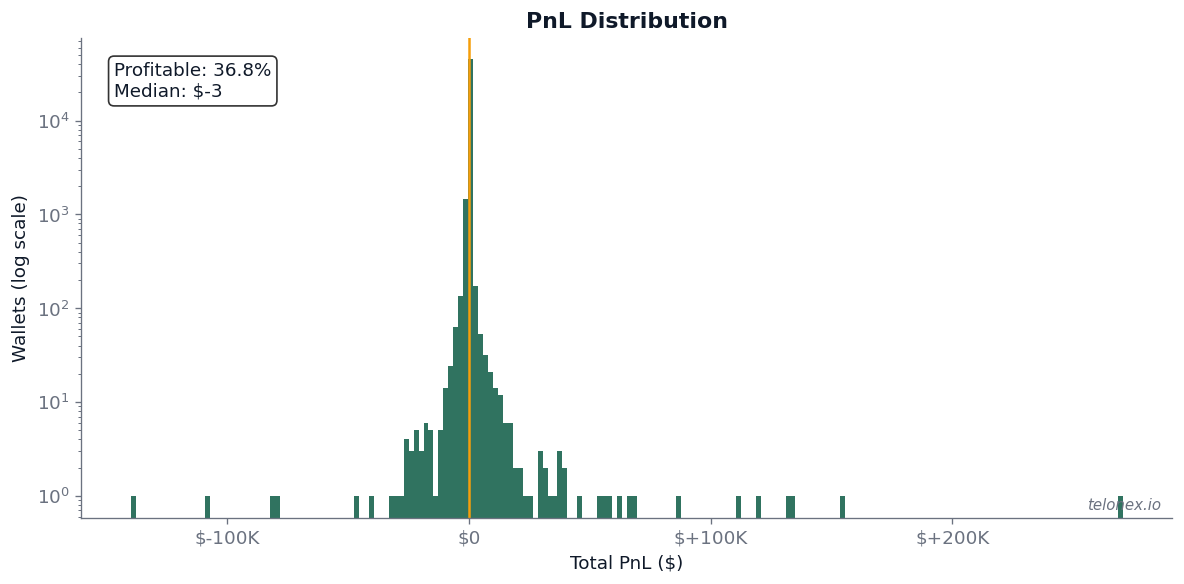

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

pnls = wallet_stats["total_pnl"]
median_pnl = pnls.median()

ax.hist(pnls, bins=200, color=TEAL, edgecolor="none", alpha=0.85)
ax.axvline(median_pnl, color=AMBER, ls="-", lw=1.5, label=f"Median: ${median_pnl:,.0f}")
ax.set_yscale("log")
ax.set_xlabel("Total PnL ($)")
ax.set_ylabel("Wallets (log scale)")
ax.set_title("PnL Distribution", fontweight="bold", color=DARK)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:+,.0f}K" if abs(x) >= 1e3 else f"${x:,.0f}"))
ax.text(0.03, 0.95, f"Profitable: {pct_profit:.1%}\nMedian: ${median_pnl:,.0f}",
        transform=ax.transAxes, fontsize=11, va="top",
        bbox=dict(boxstyle="round", fc="white", alpha=0.8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0.99, 0.01, "telonex.io", transform=ax.transAxes, ha="right",
        va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "pnl-distribution.png", bbox_inches="tight", facecolor="white")
plt.show()

## 7. Market Activity

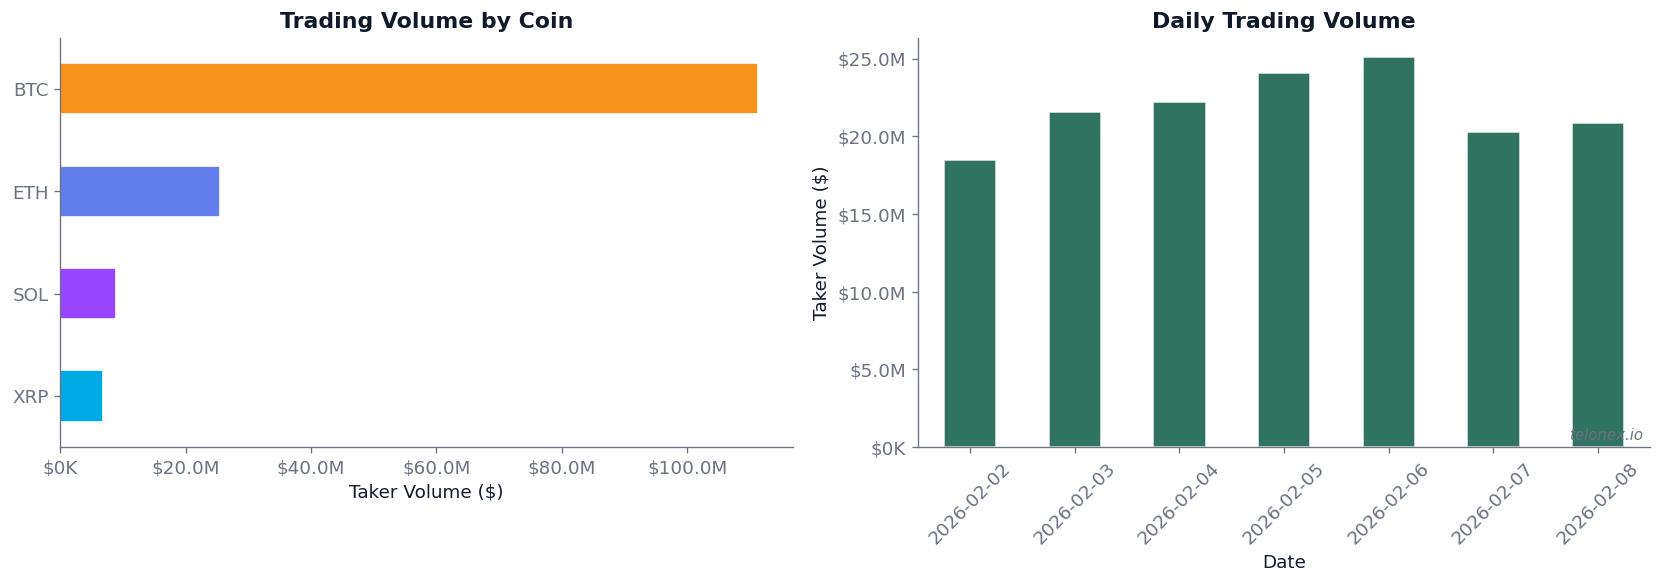

In [11]:
COIN_COLORS = {"BTC": "#F7931A", "ETH": "#627EEA", "SOL": "#9945FF", "XRP": "#00AAE4"}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — volume by coin (taker volume)
coin_vol = wallet_fills[wallet_fills["role"] == "taker"].groupby("coin")["usdc_vol"].sum().sort_values()
colors = [COIN_COLORS.get(c, TEAL) for c in coin_vol.index]
coin_vol.plot.barh(ax=axes[0], color=colors, edgecolor="white")
axes[0].set_xlabel("Taker Volume ($)")
axes[0].set_ylabel("")
axes[0].set_title("Trading Volume by Coin", fontweight="bold", color=DARK)
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e6:.1f}M" if x >= 1e6 else f"${x/1e3:.0f}K"))
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Right — daily USD volume (filtered to analysis window)
t_start = pd.Timestamp(DATE_FROM, tz="UTC")
t_end   = pd.Timestamp(DATE_TO, tz="UTC") + pd.Timedelta(days=1)
fills_week = fills[(fills["timestamp"] >= t_start) & (fills["timestamp"] < t_end)]
daily_vol = fills_week.groupby(fills_week["timestamp"].dt.date)["taker_vol"].sum()
daily_vol.plot.bar(ax=axes[1], color=TEAL, edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Taker Volume ($)")
axes[1].set_title("Daily Trading Volume", fontweight="bold", color=DARK)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e6:.1f}M" if x >= 1e6 else f"${x/1e3:.0f}K"))
axes[1].tick_params(axis="x", rotation=45)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[1].text(0.99, 0.01, "telonex.io", transform=axes[1].transAxes, ha="right",
             va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "volume-by-coin.png", bbox_inches="tight", facecolor="white")
plt.show()

## 8. Volume by Price Level

Token prices range from $0 (no chance) to $1 (certainty). Where does the volume concentrate — near the 50/50 line, or at the extremes?

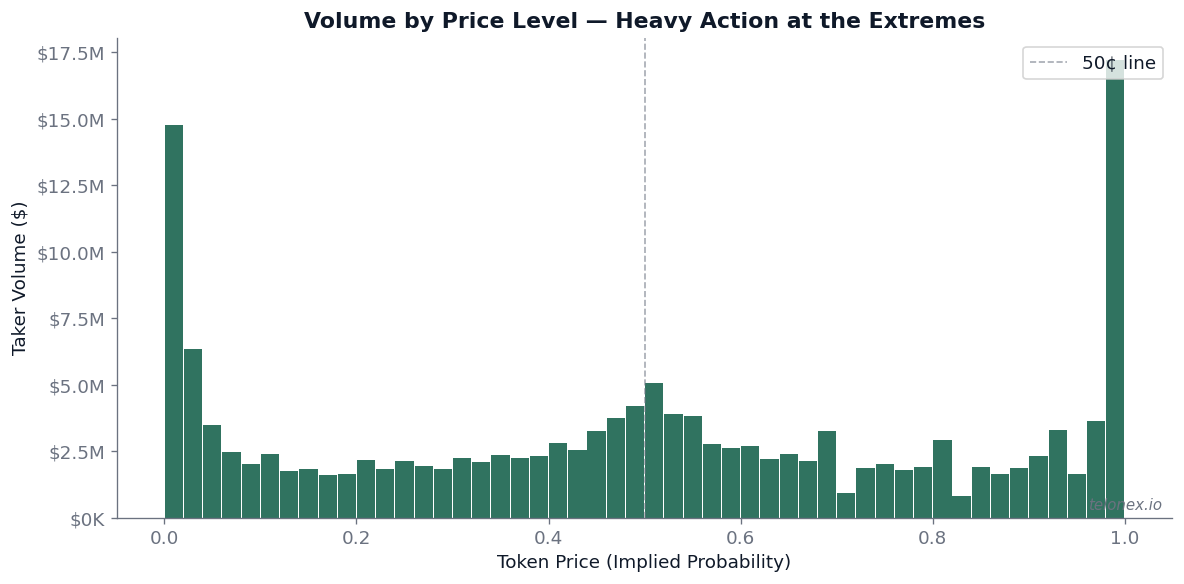

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

# Bin fills by price and sum taker volume
price_edges = np.linspace(0, 1, 51)  # 50 bins, 2¢ each
bin_idx = np.clip(np.digitize(fills["price"], price_edges) - 1, 0, 49)
vol_by_price = np.zeros(50)
np.add.at(vol_by_price, bin_idx, fills["taker_vol"].values)

centers = (price_edges[:-1] + price_edges[1:]) / 2
ax.bar(centers, vol_by_price, width=0.019, color=TEAL, edgecolor="none", alpha=0.85)
ax.axvline(0.50, color=MUTED, ls="--", lw=1, alpha=0.6, label="50¢ line")

ax.set_xlabel("Token Price (Implied Probability)")
ax.set_ylabel("Taker Volume ($)")
ax.set_title("Volume by Price Level — Heavy Action at the Extremes",
             fontweight="bold", color=DARK)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e6:.1f}M" if x >= 1e6 else f"${x/1e3:.0f}K"))
ax.legend(loc="upper right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0.99, 0.01, "telonex.io", transform=ax.transAxes, ha="right",
        va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "volume-by-price.png", bbox_inches="tight", facecolor="white")
plt.show()

## 9. Trading Activity Within the 15-Minute Window

Each market lasts exactly 15 minutes. Does trading spread evenly, or does it cluster at certain points?

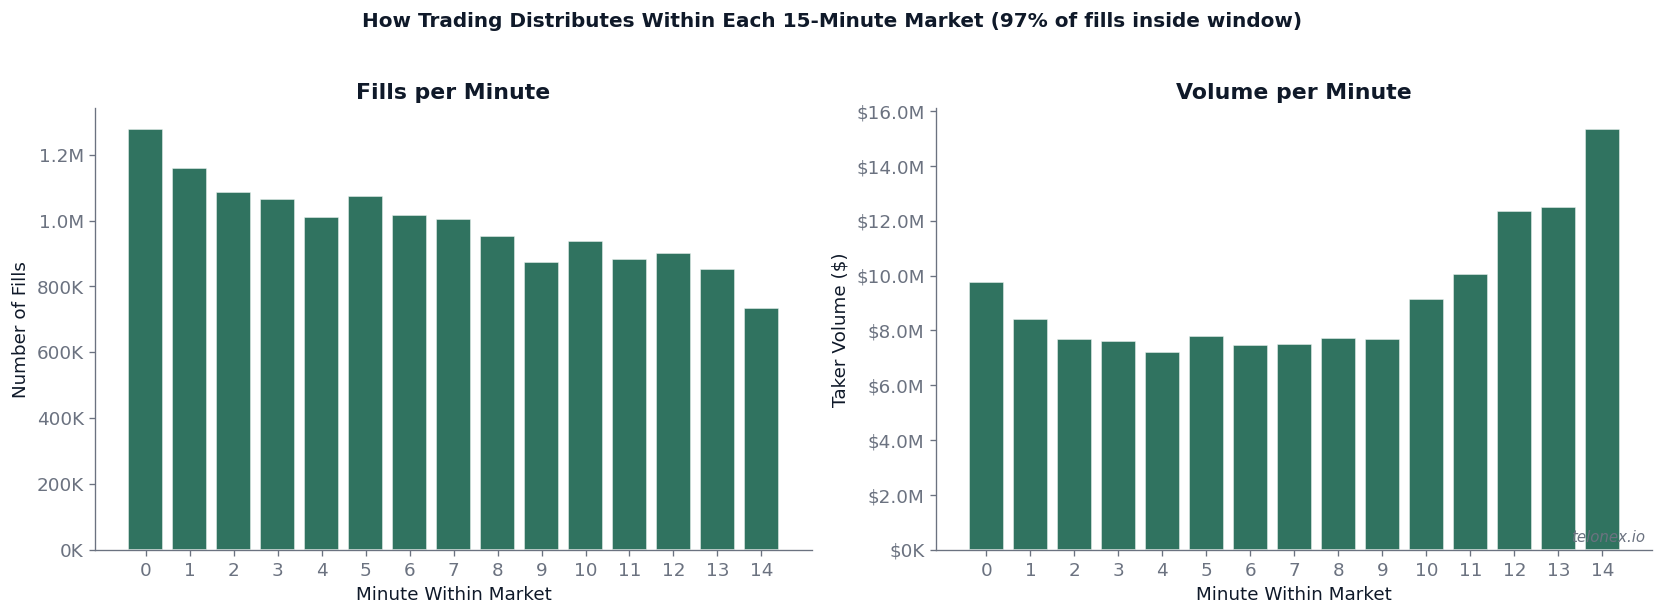

In [13]:
# Map market start time into fills
market_ts_map = markets_15m.set_index("asset_id_0")["market_ts"]
offset_s = fills["block_timestamp_us"] / 1e6 - fills["asset_id"].map(market_ts_map)

# Keep only fills within the 15-minute window [0, 900)
mask = (offset_s >= 0) & (offset_s < 900)
minute = (offset_s[mask] / 60).astype(int)  # 0–14

fills_per_min = minute.value_counts().sort_index()
vol_per_min = fills.loc[mask].groupby(minute)["taker_vol"].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — fill count per minute
axes[0].bar(fills_per_min.index, fills_per_min.values, color=TEAL, edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Minute Within Market")
axes[0].set_ylabel("Number of Fills")
axes[0].set_title("Fills per Minute", fontweight="bold", color=DARK)
axes[0].set_xticks(range(15))
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K"))
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Right — taker volume per minute
axes[1].bar(vol_per_min.index, vol_per_min.values, color=TEAL, edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Minute Within Market")
axes[1].set_ylabel("Taker Volume ($)")
axes[1].set_title("Volume per Minute", fontweight="bold", color=DARK)
axes[1].set_xticks(range(15))
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e6:.1f}M" if x >= 1e6 else f"${x/1e3:.0f}K"))
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[1].text(0.99, 0.01, "telonex.io", transform=axes[1].transAxes, ha="right",
             va="bottom", fontsize=9, color=MUTED, style="italic")

pct_in_window = mask.sum() / len(fills) * 100
fig.suptitle(f"How Trading Distributes Within Each 15-Minute Market ({pct_in_window:.0f}% of fills inside window)",
             fontsize=12, fontweight="bold", color=DARK, y=1.02)
plt.tight_layout()
fig.savefig(IMG_DIR / "fills-per-minute.png", bbox_inches="tight", facecolor="white")
plt.show()

Fill count is highest at the open and tapers off — but **volume spikes in the final minutes**. As the outcome becomes clearer, fewer traders participate, but those who do place larger bets at more extreme prices.

## 10. Maker Ratio vs. PnL

Does being a maker (providing liquidity) or a taker (aggressing) lead to better outcomes?

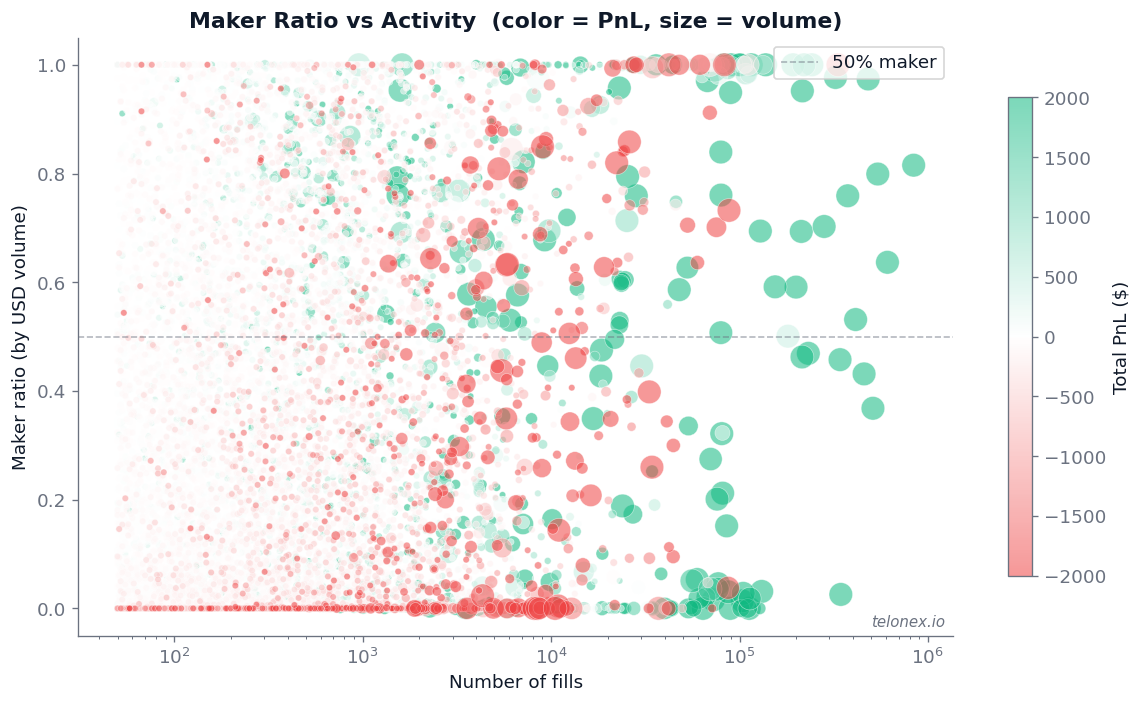

In [14]:
cmap_pnl = LinearSegmentedColormap.from_list("telonex_pnl", [RED, "#FFFFFF", GREEN])

active = wallet_stats[wallet_stats["num_fills"] >= 50].copy()

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(
    active["num_fills"], active["maker_vol_pct"],
    c=active["total_pnl"], cmap=cmap_pnl, vmin=-2000, vmax=2000,
    s=np.clip(active["volume"] / active["volume"].quantile(0.99) * 120, 15, 200),
    alpha=0.55, edgecolors="white", linewidth=0.4,
)
ax.axhline(0.5, color=MUTED, ls="--", lw=1, alpha=0.5, label="50% maker")
ax.set_xlabel("Number of fills")
ax.set_ylabel("Maker ratio (by USD volume)")
ax.set_xscale("log")
ax.set_title("Maker Ratio vs Activity  (color = PnL, size = volume)",
             fontweight="bold", color=DARK)
ax.legend(loc="upper right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.colorbar(sc, ax=ax, label="Total PnL ($)", shrink=0.8)
ax.text(0.99, 0.01, "telonex.io", transform=ax.transAxes, ha="right",
        va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "maker-ratio-vs-activity.png", bbox_inches="tight", facecolor="white")
plt.show()

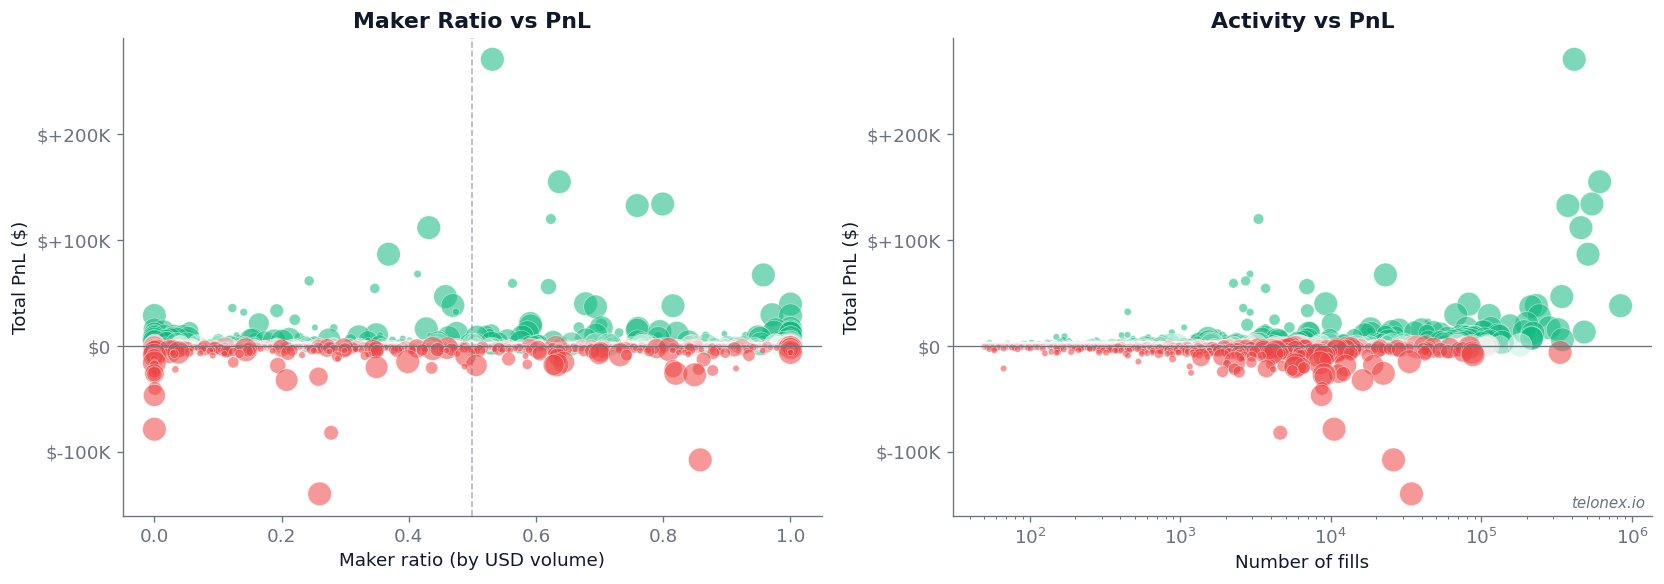

In [15]:
active = wallet_stats[wallet_stats["num_fills"] >= 50].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — Maker ratio (by volume) vs PnL
sc1 = axes[0].scatter(
    active["maker_vol_pct"], active["total_pnl"],
    c=active["total_pnl"], cmap=cmap_pnl, vmin=-2000, vmax=2000,
    s=np.clip(active["volume"] / active["volume"].quantile(0.99) * 120, 15, 200),
    alpha=0.55, edgecolors="white", linewidth=0.4,
)
axes[0].axhline(0, color=MUTED, ls="-", lw=0.8)
axes[0].axvline(0.5, color=MUTED, ls="--", lw=1, alpha=0.5)
axes[0].set_xlabel("Maker ratio (by USD volume)")
axes[0].set_ylabel("Total PnL ($)")
axes[0].set_title("Maker Ratio vs PnL", fontweight="bold", color=DARK)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:+,.0f}K" if abs(x) >= 1e3 else f"${x:,.0f}"))
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Right — Number of fills vs PnL
sc2 = axes[1].scatter(
    active["num_fills"], active["total_pnl"],
    c=active["total_pnl"], cmap=cmap_pnl, vmin=-2000, vmax=2000,
    s=np.clip(active["volume"] / active["volume"].quantile(0.99) * 120, 15, 200),
    alpha=0.55, edgecolors="white", linewidth=0.4,
)
axes[1].axhline(0, color=MUTED, ls="-", lw=0.8)
axes[1].set_xlabel("Number of fills")
axes[1].set_ylabel("Total PnL ($)")
axes[1].set_xscale("log")
axes[1].set_title("Activity vs PnL", fontweight="bold", color=DARK)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:+,.0f}K" if abs(x) >= 1e3 else f"${x:,.0f}"))
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[1].text(0.99, 0.01, "telonex.io", transform=axes[1].transAxes, ha="right",
             va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "maker-ratio-and-activity-vs-pnl.png", bbox_inches="tight", facecolor="white")
plt.show()

## 11. What Do the Top Wallets Trade?

Coin-level PnL breakdown for the top 10 most profitable wallets.

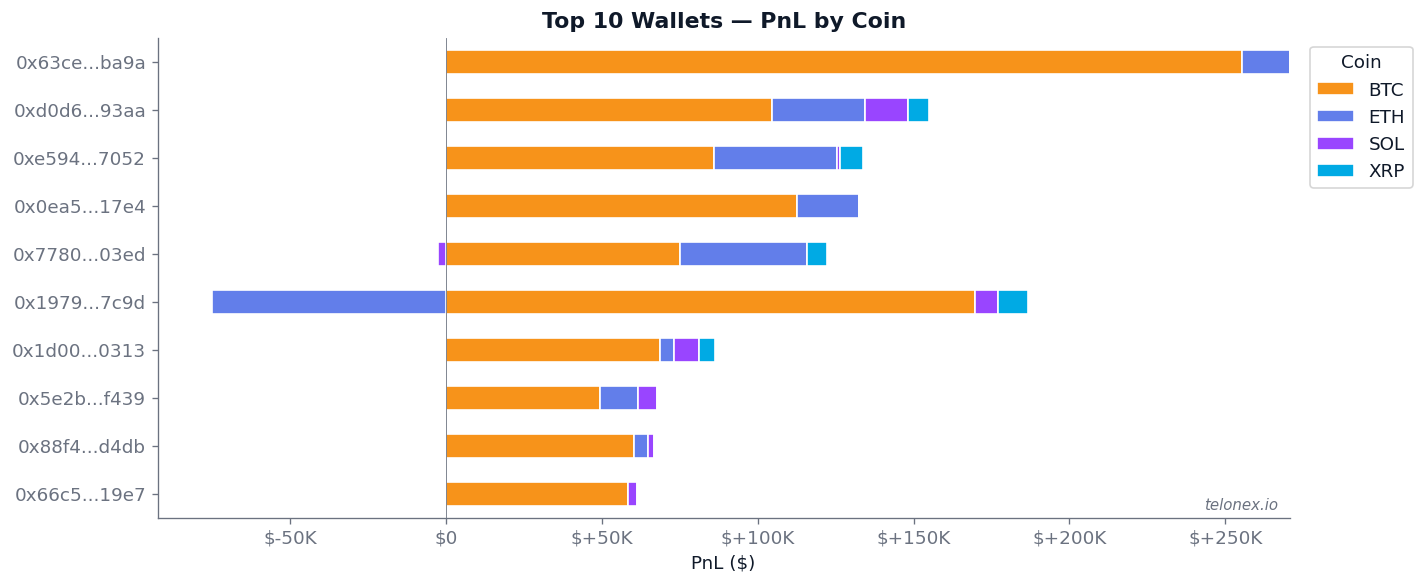

In [16]:
top10_addrs = wallet_stats.head(10)["wallet"].values
top10_fills  = wallet_fills[wallet_fills["wallet"].isin(top10_addrs)]

pivot = top10_fills.groupby(["wallet", "coin"])["pnl"].sum().unstack(fill_value=0)
pivot = pivot.loc[top10_addrs]  # preserve rank order
pivot.index = [short(a) for a in pivot.index]

fig, ax = plt.subplots(figsize=(12, 5))
pivot.plot.barh(
    stacked=True, ax=ax,
    color=[COIN_COLORS.get(c, TEAL) for c in pivot.columns],
    edgecolor="white",
)
ax.axvline(0, color=MUTED, ls="-", lw=0.5)
ax.set_xlabel("PnL ($)")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:+,.0f}K" if abs(x) >= 1e3 else f"${x:,.0f}"))
ax.set_title("Top 10 Wallets — PnL by Coin", fontweight="bold", color=DARK)
ax.legend(title="Coin", bbox_to_anchor=(1.01, 1), loc="upper left")
ax.invert_yaxis()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0.99, 0.01, "telonex.io", transform=ax.transAxes, ha="right",
        va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "pnl-by-coin.png", bbox_inches="tight", facecolor="white")
plt.show()

## 12. When Do the Sharpest Wallets Trade?

Are the top wallets bots running 24/7, or humans trading specific sessions?

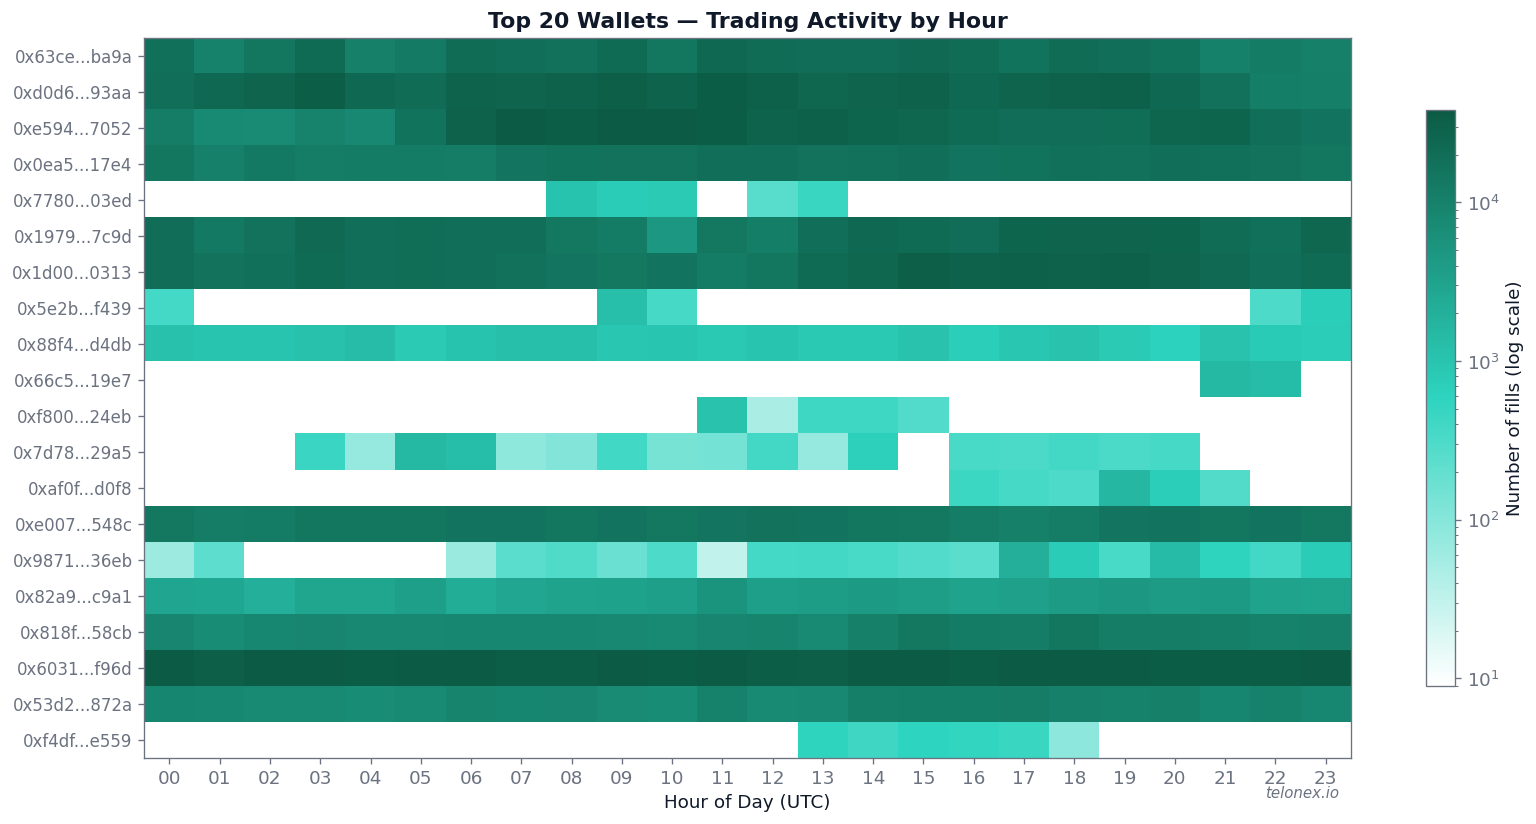

In [17]:
# Hour-of-day activity heatmap for the top 20 wallets
cmap_heat = LinearSegmentedColormap.from_list("telonex_heat", ["#FFFFFF", CYAN, TEAL])

top20_addrs = wallet_stats.head(20)["wallet"].values
top20_wf = wallet_fills[wallet_fills["wallet"].isin(top20_addrs)].copy()
top20_wf["hour"] = top20_wf["timestamp"].dt.hour

heat = top20_wf.groupby(["wallet", "hour"]).size().unstack(fill_value=0)
heat = heat.reindex(columns=range(24), fill_value=0)  # ensure all 24 hours
heat = heat.loc[top20_addrs]  # preserve rank order
heat.index = [short(a) for a in heat.index]

# Replace zeros with NaN so they stay white, use log scale for the rest
heat_vals = heat.values.astype(float)
heat_vals[heat_vals == 0] = np.nan
vmin = np.nanmin(heat_vals)
vmax = np.nanmax(heat_vals)

fig, ax = plt.subplots(figsize=(14, 7))
im = ax.imshow(heat_vals, aspect="auto", cmap=cmap_heat,
               norm=LogNorm(vmin=max(1, vmin), vmax=vmax))
ax.set_xticks(range(24))
ax.set_xticklabels([f"{h:02d}" for h in range(24)])
ax.set_yticks(range(len(heat)))
ax.set_yticklabels(heat.index, fontsize=10)
ax.set_xlabel("Hour of Day (UTC)")
ax.set_title("Top 20 Wallets — Trading Activity by Hour",
             fontweight="bold", color=DARK)
plt.colorbar(im, ax=ax, label="Number of fills (log scale)", shrink=0.8)
ax.text(0.99, -0.06, "telonex.io", transform=ax.transAxes, ha="right",
        va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "heatmap.png", bbox_inches="tight", facecolor="white")
plt.show()

## 13. Edge Leaderboard (PnL per $ Traded)

Raw PnL favors whales. **Edge** (PnL / Volume) measures how much profit a wallet extracts per dollar of volume — a better gauge of skill. Minimum $10K volume to qualify.

In [18]:
# Edge = PnL / Volume, with minimum $10K volume filter
min_vol = 10_000
roi_eligible = wallet_stats[wallet_stats["volume"] >= min_vol].copy()
roi_eligible["edge"] = roi_eligible["total_pnl"] / roi_eligible["volume"]
roi_top = roi_eligible.sort_values("edge", ascending=False).head(20).copy()
roi_top.insert(0, "rank", range(1, 21))
roi_top["wallet"] = roi_top["wallet"].apply(short)

show_roi = roi_top[["rank", "wallet", "edge", "total_pnl", "volume",
                     "num_fills", "num_markets", "maker_fill_pct"]].copy()
show_roi.columns = ["#", "Wallet", "Edge", "PnL ($)", "Volume ($)",
                     "Fills", "Markets", "Maker %"]
show_roi["Edge"]       = show_roi["Edge"].map("{:.1%}".format)
show_roi["PnL ($)"]    = show_roi["PnL ($)"].map("${:,.0f}".format)
show_roi["Volume ($)"] = show_roi["Volume ($)"].map("${:,.0f}".format)
show_roi["Maker %"]    = show_roi["Maker %"].map("{:.0%}".format)

print(f"TOP 20 BY EDGE (PnL / Volume, min ${min_vol:,} volume, {len(roi_eligible):,} eligible wallets)")
print(show_roi.to_string(index=False))

TOP 20 BY EDGE (PnL / Volume, min $10,000 volume, 2,565 eligible wallets)
 #        Wallet   Edge  PnL ($) Volume ($)  Fills  Markets Maker %
 1 0x5e2b...f439 155.1%  $67,708    $43,659   2904        8     25%
 2 0x7780...03ed 137.1% $119,675    $87,260   3305       11     47%
 3 0xdb21...39ff 108.7%  $12,697    $11,686    877      129      0%
 4 0x858c...a5a0  85.1%  $17,247    $20,266   1060       10     25%
 5 0xf800...24eb  81.8%  $58,914    $72,058   2253       10     45%
 6 0x7163...a9e5  80.9%  $14,547    $17,978  18118     2060    100%
 7 0xf49a...f9ba  80.3%  $23,011    $28,641  44120     2666    100%
 8 0x66c5...19e7  79.5%  $61,201    $77,004   2715        6     18%
 9 0x0e7d...c13a  78.3%  $32,014    $40,891    447       81     33%
10 0xaf0f...d0f8  69.5%  $54,133    $77,917   3684       18     21%
11 0x3c02...5a6d  68.5%   $8,419    $12,297  14948     1202    100%
12 0xc8d4...dc5b  68.4%  $31,657    $46,314   2906       23     17%
13 0xf4df...e559  56.9%  $35,554    $62,52

## 14. Makers vs Takers

Are market makers (liquidity providers) or takers (aggressive traders) making more money?

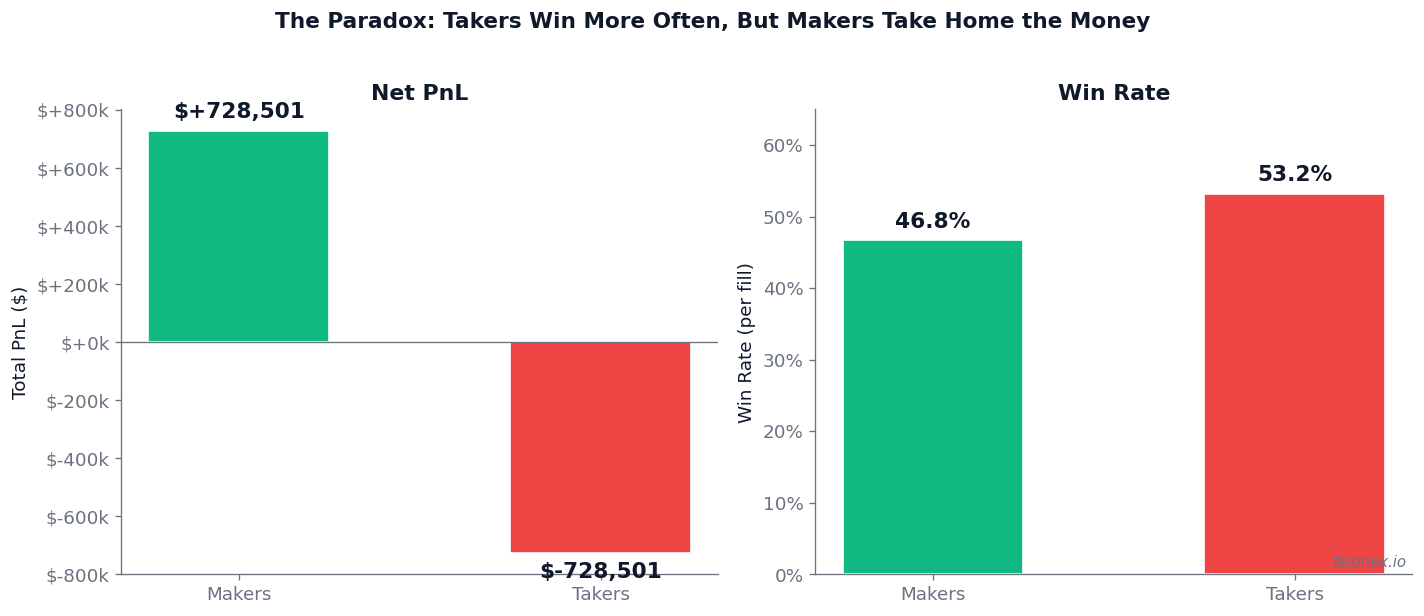


  MAKER   |  PnL: $     728,501  |  Avg PnL/fill: $   0.047  |  Win rate: 46.8%  |  Wallets: 19,845
  TAKER   |  PnL: $    -728,501  |  Avg PnL/fill: $  -0.047  |  Win rate: 53.2%  |  Wallets: 42,343


In [19]:
role_stats = wallet_fills.groupby("role").agg(
    total_pnl  = ("pnl",      "sum"),
    avg_pnl    = ("pnl",      "mean"),
    total_vol  = ("usdc_vol", "sum"),
    fills      = ("pnl",      "count"),
    wallets    = ("wallet",   "nunique"),
)
role_stats["win_rate"] = wallet_fills.groupby("role")["pnl"].apply(lambda x: (x > 0).mean())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Net PnL
maker_pnl = role_stats.loc["maker", "total_pnl"]
taker_pnl = role_stats.loc["taker", "total_pnl"]
bars1 = axes[0].bar(["Makers", "Takers"], [maker_pnl, taker_pnl],
                    color=[GREEN, RED], width=0.5, edgecolor="white")
axes[0].bar_label(bars1, labels=[f"${v:+,.0f}" for v in [maker_pnl, taker_pnl]],
                  fontsize=13, fontweight="bold", padding=5)
axes[0].set_ylabel("Total PnL ($)")
axes[0].set_title("Net PnL", fontweight="bold", color=DARK)
axes[0].axhline(0, color=MUTED, lw=0.8)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:+,.0f}k"))
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Right: Win Rate (the paradox)
maker_wr = role_stats.loc["maker", "win_rate"]
taker_wr = role_stats.loc["taker", "win_rate"]
bars2 = axes[1].bar(["Makers", "Takers"], [maker_wr, taker_wr],
                    color=[GREEN, RED], width=0.5, edgecolor="white")
axes[1].bar_label(bars2, labels=[f"{v:.1%}" for v in [maker_wr, taker_wr]],
                  fontsize=13, fontweight="bold", padding=5)
axes[1].set_ylabel("Win Rate (per fill)")
axes[1].set_title("Win Rate", fontweight="bold", color=DARK)
axes[1].set_ylim(0, 0.65)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0%}"))
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

fig.suptitle("The Paradox: Takers Win More Often, But Makers Take Home the Money",
             fontsize=13, fontweight="bold", color=DARK, y=1.02)
axes[1].text(0.99, 0.01, "telonex.io", transform=axes[1].transAxes, ha="right",
             va="bottom", fontsize=9, color=MUTED, style="italic")
plt.tight_layout()
fig.savefig(IMG_DIR / "makers-vs-takers.png", bbox_inches="tight", facecolor="white")
plt.show()

print()
for role in ["maker", "taker"]:
    r = role_stats.loc[role]
    print(f"  {role.upper():6s}  |  PnL: ${r['total_pnl']:>12,.0f}  |  "
          f"Avg PnL/fill: ${r['avg_pnl']:>8,.3f}  |  "
          f"Win rate: {r['win_rate']:.1%}  |  "
          f"Wallets: {int(r['wallets']):,}")

## 15. The Bottom Line

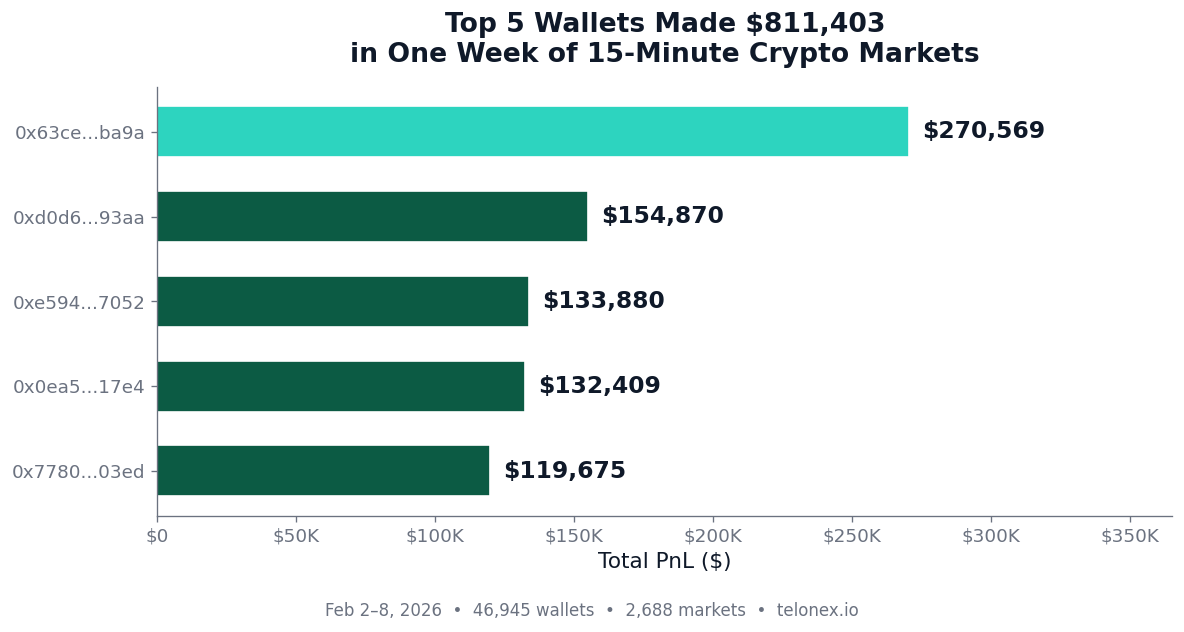

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
top5 = wallet_stats.head(5).copy()
top5["label"] = top5["wallet"].apply(short)
colors = [CYAN if i == 0 else TEAL for i in range(5)]
bars = ax.barh(top5["label"], top5["total_pnl"], color=colors, edgecolor="white", height=0.6)
ax.bar_label(bars, labels=[f"${v:,.0f}" for v in top5["total_pnl"]],
             padding=8, fontsize=14, fontweight="bold", color=DARK)
ax.invert_yaxis()
ax.set_xlabel("Total PnL ($)", fontsize=13)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f"${x/1e3:,.0f}K" if x >= 1e3 else f"${x:,.0f}"))
ax.set_title(f"Top 5 Wallets Made ${top5['total_pnl'].sum():,.0f}\nin One Week of 15-Minute Crypto Markets",
             fontsize=16, fontweight="bold", color=DARK, pad=15)
ax.set_xlim(0, top5["total_pnl"].max() * 1.35)
ax.spines[["top", "right"]].set_visible(False)
fig.text(0.5, -0.04,
         f"Feb 2\u20138, 2026  \u2022  {n_wallets:,} wallets  \u2022  {n_markets:,} markets  \u2022  telonex.io",
         ha="center", fontsize=10, color=MUTED)
plt.tight_layout()
fig.savefig(IMG_DIR / "hero-top5.png", bbox_inches="tight", facecolor="white")
plt.show()

In [21]:
top5_pnl = wallet_stats.head(5)["total_pnl"].sum()
maker_net = role_stats.loc["maker", "total_pnl"]
taker_wr_pct = role_stats.loc["taker", "win_rate"]

print("KEY TAKEAWAYS")
print("=" * 64)
print(f"  ${total_vol/1e6:.0f}M flowed through 15-minute crypto markets in")
print(f"  just one week. {n_wallets:,} wallets competed across {n_markets:,}")
print(f"  markets — only {pct_profit:.0%} turned a profit.")
print()
print(f"  The top 5 wallets captured ${top5_pnl:,.0f} combined,")
print(f"  dominated by BTC — the most liquid 15M market.")
print()
print(f"  Takers win {taker_wr_pct:.0%} of individual fills but lose money")
print(f"  overall. Makers net +${maker_net:,.0f} — the spread is")
print(f"  their edge. Win rate is misleading in these markets.")
print()
print(f"  Some wallets scored big on just a handful of markets")
print(f"  (see the leaderboard) — the Edge table separates")
print(f"  sustained edge from lucky streaks.")
print("=" * 64)

KEY TAKEAWAYS
  $153M flowed through 15-minute crypto markets in
  just one week. 46,945 wallets competed across 2,688
  markets — only 37% turned a profit.

  The top 5 wallets captured $811,403 combined,
  dominated by BTC — the most liquid 15M market.

  Takers win 53% of individual fills but lose money
  overall. Makers net +$728,501 — the spread is
  their edge. Win rate is misleading in these markets.

  Some wallets scored big on just a handful of markets
  (see the leaderboard) — the Edge table separates
  sustained edge from lucky streaks.


## 16. Future Research

This analysis covers the broad strokes — who's winning, who's losing, and the overall market structure. But the on-chain data contains far more signal than a single week-long overview can capture. Here are threads we found interesting but didn't dig into:

- **Cross-token strategies.** Wallet 0x1979...7c9d (#6, $111K PnL) trades all four coins but shows a net loss on ETH. Is it running a cross-token hedging strategy — going long BTC volatility and short ETH simultaneously? Or is the ETH order book simply harder to make money in?

- **Pure market maker mechanics.** Several wallets in the edge leaderboard have 100% maker ratio (e.g., 0x7163, 0xf49a, 0x3c02). How tight are their spreads? How quickly do they update quotes after a fill? How do they manage inventory risk across thousands of consecutive 15-minute markets?

- **Whale vs. sniper strategies.** Wallet #1 (0x63ce, $270K PnL) traded 1,168 markets with moderate size per trade ($6K/market). Wallet #5 (0x7780, $119K) traded just 11 markets with massive bets ($7.9K/market but far fewer markets). Are the "snipers" timing entries based on external signals (e.g., Binance or Coinbase spot price feeds)?

- **Order flow toxicity.** Which makers get adversely selected most? Do certain taker wallets consistently pick off stale maker quotes right before price moves? A maker-level fill analysis could reveal which takers are "toxic" flow.

- **Time-of-day alpha.** The heatmap shows diverse trading patterns across top wallets. Do certain wallets systematically outperform during specific sessions? Is there alpha at market open vs. close (the intra-market volume spike at close suggests there might be)?

- **Intra-market timing by wallet.** We showed that fills peak at the open and volume spikes at the close — but do specific wallets favour different parts of the 15-minute window? Do the best makers quote from open to close while snipers concentrate in the final minutes?

- **Fee-adjusted profitability.** This analysis uses pre-fee PnL. Polymarket charges dynamic taker fees and offers maker rebates — after accounting for these, how many wallets are truly profitable? The 37% number would almost certainly drop.

- **Inventory curves and risk management** — How do top market makers manage their exposure within and across markets? By tracking a wallet's net position over time, you can reconstruct its inventory curve — revealing risk tolerances, how quickly they flatten exposure, and how long they hold directional risk before hedging or exiting.

- **Volatility effects.** How does underlying crypto volatility affect profitability, volume, and market structure? During high-vol periods, do makers get picked off more? Do takers perform better because prices move further? A week-over-week comparison across different volatility regimes could reveal regime-dependent strategies.

Each of these could be its own deep-dive analysis.

---

*This analysis was built with data from [Telonex](https://telonex.io). Want to run your own? Sign up for free at [telonex.io](https://telonex.io) and start pulling granular prediction market data in minutes.*

**Full article:** [telonex.io/research/top-crypto-traders-polymarket-15m](http://telonex.io/research/top-crypto-traders-polymarket-15m)